# CMSC 35350 - Neuromorphic Computing
Final project Jupyter notebook

----------
### Topic:
## "Unsupervised Learning by neuromorphic network"

Build an unsupervised learning network, autoencoder, using Python neuromophic computing libraries `Nengo/Nengo DL`. Nengo and NengoDL wrapped PyNN, "a simulator-independent language for building neuronal network models", to easily create hands-on neural similations. Plus the library provides the integration with a common neural network Tnesorflow, which makes users code by the popular manner.

### Library requirement
Check whether libraries below are installed.
- nengo
- nengo_dl
- tensorflow

Additional library for analysis
- scikit-learn

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

import nengo
import nengo_dl
import tensorflow as tf

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/version.py:32: UserWarning: This version of `nengo_dl` has not been tested with your `nengo` version (3.0.0.dev0). The latest fully supported version is 2.8.0.
  ((nengo.version.version,) + latest_nengo_version))


#### Load MNIST dataset

In [39]:
# load mnist dataset
if not os.path.exists('mnist.pkl.gz'):
    urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz",
            "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz") as f:
    (_train_data, _), _, (_test_data, test_label) = pickle.load(
        f, encoding="latin1")
np.random.shuffle(_train_data)

In [40]:
# reshape to parse
train_data = _train_data[:, None, :]
test_data = _test_data[:, None, :]

#### Set params

In [5]:
n_in = 784
n_hidden = 64
minibatch_size = 50

--------------

#### Build Network
Build nengo-simulation model.  
3 layers simple encode-decode network with `784 -> 64 -> 784` nodes.

In [43]:
with nengo.Network() as autoencoder:
    # input layer
    nengo_input  = nengo.Node(np.zeros(n_in))

    # Bottleneck layer
    nengo_b = nengo.Ensemble(
        n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_input, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # output layer
    nengo_out = nengo.Ensemble(
        n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_out.neurons,
        transform=nengo_dl.dists.Glorot())
    
    # outout layer for spiking
    b_spike = nengo.Ensemble(
        n_in, 1, neuron_type=nengo.SpikingRectifiedLinear())
    nengo.Connection(nengo_b.neurons, b_spike,transform=nengo_dl.dists.Glorot())

    # probes to collect data
    p_b   = nengo.Probe(nengo_b.neurons)   #extract bottleneck layer
    p_out = nengo.Probe(nengo_out.neurons) #outpit==ut layer

In [44]:
# set initial neuron gains to 1 and biases to 0
for ens in autoencoder.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in autoencoder.all_connections:
    conn.synapse = None

#### Loss function

In [8]:
def loss(outputs, targets):
    #binary crossentropy
    return tf.reduce_mean(tf.keras.backend.binary_crossentropy(
        target=targets, output=outputs))

#### Training model

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|#########Constructing graph: creating base arrays (400%)########################################################################################################################################################################################################| ETA: 0:00:00

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Construction finished in 0:00:01                                               ##################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################| ETA: 0:00:00


/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:1609: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x7fc2a535c828>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  "are properly freed." % self.model, RuntimeWarning)


Training finished in 0:01:22 (loss: 0.2758)                                    
Calculation finished in 0:00:02                                                
error: 0.28202403


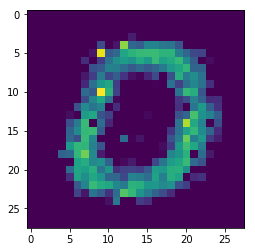

In [68]:
n_epochs = 2 # epoch
le = 1.0e-3  # learning rate
# optimizer: Adam
# Loss: binary cross-entoropy
with nengo_dl.Simulator(autoencoder, minibatch_size=minibatch_size) as sim:
    # train on train data
    sim.train({nengo_input: train_data, p_out: train_data},
              tf.train.AdamOptimizer(le),
              objective={p_out: loss}, n_epochs=n_epochs)

    # check performance on test set
    error = sim.loss({nengo_input: test_data, p_out: test_data},
                     objective={p_out: loss})
    print("error:", error)
    
    # display a decoded example
    sim.step(data={nengo_input: test_data[:minibatch_size]})
    plt.figure()
    plt.imshow(sim.data[p_out][10].reshape((28, 28)))

#### Visualize firing rates on the bottleneck vector with 2D Heatmap
Map 64 vector to 8 by 8 embedding array to show how the network exhibits different fireing arte to different numbers 

In [76]:
# Run model to get enough simulated data
with nengo_dl.Simulator(autoencoder, minibatch_size=minibatch_size*2) as sim2:
    sim2.step(data={nengo_input: test_data[:minibatch_size*2]})

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|         Constructing graph: creating base arrays (0%)        | ETA:  --:--:--

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "


Construction finished in 0:00:00                                               ##################################################################################################################################################################################################################################################################################################################################################################################################################################################| ETA: 0:00:00


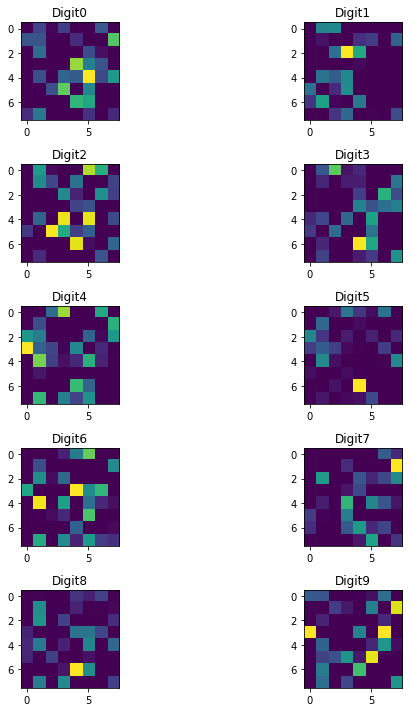

In [78]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    idx = np.where(test_label == i)[0][0]
    if idx < minibatch_size*2:
        ax = plt.subplot(5,2,i+1)
        plt.imshow(sim2.data[p_b].reshape(minibatch_size*2,8,8)[idx])
        ax.set_title('Digit'+str(i))
fig.tight_layout()
plt.show()

#### Visualize encoded & decoded imgs

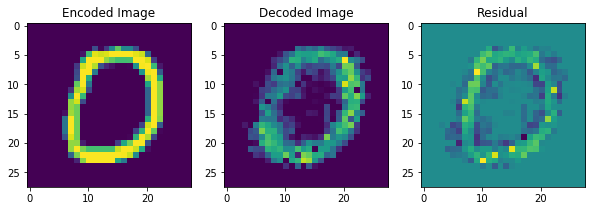

In [11]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(131)
plt.imshow(test_data[10].reshape((28, 28)))
ax.set_title("Encoded Image")
ax = plt.subplot(132)
plt.imshow(sim.data[p_out][10].reshape((28, 28)))
ax.set_title("Decoded Image")
ax = plt.subplot(133)
plt.imshow(test_data[10].reshape(28, 28) - sim.data[p_out][10].reshape((28, 28)) )
ax.set_title("Residual")
plt.show()

-------------------

### Analyze bottleneck layer with PCA

Visualize bottleneck layer by reducing its dimension by PCA. Show the spatioal location of the reduced dimension feature expression.

In [12]:
from sklearn.decomposition import PCA
# num of cluster
n_cluster = 10

# get nparray 
bottleneck_layer = np.squeeze(sim.data[p_b])

# Compute the clusters
pca = PCA(n_components=n_cluster)
features = pca.fit_transform(bottleneck_layer)

In [13]:
import matplotlib  
#.colors #import Colormap
def _get_colors(n=-1, cmap_name='jet'):
    # colormap
    cmap = matplotlib.cm.get_cmap(cmap_name, n)
    colors = []
    for idx, i in enumerate(range(cmap.N)):
        rgb = cmap(i)[:3]
        #print(idx, matplotlib.colors.rgb2hex(rgb))
        colors += [matplotlib.colors.rgb2hex(rgb)]
    return colors

Text(0.5, 1.0, 'PCA to bottleneck layer')

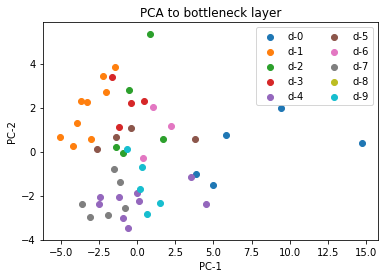

In [14]:
colors = _get_colors(n=n_cluster)
for i in range(n_cluster):
    cidx = np.where(test_label[:50] == i)
    plt.scatter(features[cidx,0], features[cidx,1], label='d-'+str(i))
plt.legend(ncol=2, loc='upper right')
#plt.ylim(-300,300);plt.xlim(-400,300)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('PCA to bottleneck layer')